# Optimizing rho and l2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from echo import esn

In [2]:
# Experiments with rho, with fixed normalization strength

data = esn.Data.create_source('lorenz')

points_to_skip = 300
training_signal_length = 10000
test_length = 500
n_units = 100
n_edges = 2000
n_experiments = 10

rhos = [None, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
l2s = [0, 0.000001, 0.00001, 0.0001, 0.001]

loss_train = np.zeros((len(rhos), len(l2s), n_experiments))
loss_test = np.zeros((len(rhos), len(l2s), n_experiments))

seeds = np.random.uniform(size=n_experiments) # We always train on same data, but with different networks

for (i_rho, rho) in enumerate(rhos):
    for (i_l2, l2) in enumerate(l2s):
        for i_exp in range(n_experiments):
            x1,y1 = data.generate(points_to_skip + training_signal_length, seed=seeds[i_exp])
            x2,y2 = data.generate(points_to_skip + training_signal_length, seed=1)

            model = esn.Reservoir(n_units, n_edges=n_edges, rho=rho, l2=l2, network_type='erdos',
                                 inhibition='distributed', weights_in='flat')
            model.fit(x1, y1, skip=points_to_skip)

            # Training data loss    
            z = model.predict(x1, length=points_to_skip+test_length)     
            loss_train[i_rho, i_l2, i_exp] = esn.utils.loss(y1[points_to_skip:(points_to_skip+test_length)], z[points_to_skip:])        

            # Testing loss        
            z = model.predict(x2, length=points_to_skip+test_length)     
            loss_test[i_rho, i_l2, i_exp] = esn.utils.loss(y2[points_to_skip:(points_to_skip+test_length)], z[points_to_skip:])
            print('.', end='')
        print(';', end='')
    print('|', end='')
print('Done')

..........;..........;..........;..........;..........;|..........;..........;..........;..........;..........;|..........;..........;..........;..........;..........;|..........;..........;..........;..........;..........;|..........;..........;..........;..........;..........;|..........;..........;..........;..........;..........;|..........;..........;..........;..........;..........;|Done


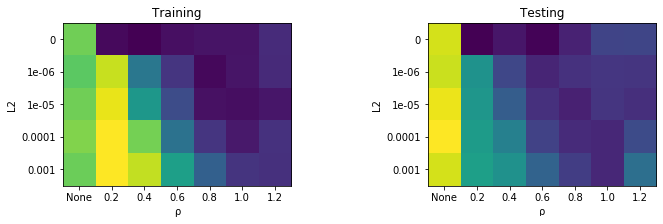

In [4]:
# 2D heatplots of both hyperparameters
def plot2d(x, y, z, label=None, xlabel=None, ylabel=None):
    plt.imshow(z.T) # Important: matrices have columns first :)
    plt.xticks(np.arange(len(x)), labels=[str(e) for e in x])
    plt.yticks(np.arange(len(y)), labels=[str(e) for e in y])
    plt.title(label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

plt.figure(figsize=(12,3))
plt.subplot(121)
lts = np.mean(loss_train, axis=2)
plot2d(rhos, l2s, lts, 'Training', 'ρ', 'L2')
plt.subplot(122)
lss = np.mean(loss_test, axis=2)
plot2d(rhos, l2s, lss, 'Testing', 'ρ', 'L2')

It seems that the smaller L2, the better, which is seriously weird, as it goes against the intuition of how regularization works. Does it mean that we are really far from overfitting?

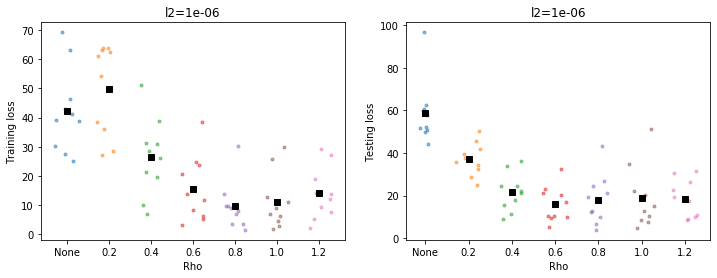

In [5]:
# Transsections
def plot1d(x, y, xlabel=None, ylabel=None, title=None):
    y = np.squeeze(y) # We expect sngleton dimensions here
    xticklabels = [str(e) for e in x]    
    for i,label in enumerate(x):
        plt.plot(i + np.random.uniform(size=y.shape[1])*0.6 - 0.3, y[i,:], '.', alpha=0.5)
        plt.plot(i, np.mean(y[i,:]), 'sk')
    plt.xticks(np.arange(len(x)), labels=xticklabels)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
        
plt.figure(figsize=(12,4))
plt.subplot(121)
plot1d(rhos, loss_train[:,1,:], 'Rho', 'Training loss', f'l2={l2s[1]}')
plt.subplot(122)
plot1d(rhos, loss_test[:,1,:], 'Rho', 'Testing loss', f'l2={l2s[1]}')

**Conclusion:** Both training and testing losses are atrocious, but values of ρ around 0.6-0.8 seems to give slightly better values. If we pick 0.8, it would make it the number of choice for both "standard" (alternating) design, and for the distributed design.

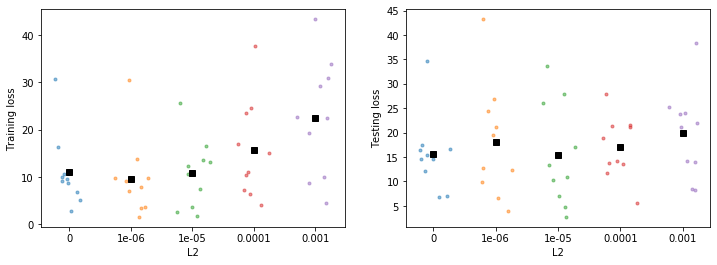

In [6]:
# Other transsection
plt.figure(figsize=(12,4))
plt.subplot(121)
plot1d(l2s, loss_train[4,:,:], 'L2', 'Training loss')
plt.subplot(122)
plot1d(l2s, loss_test[4,:,:], 'L2', 'Testing loss')

It seems that smaller l2 are better.